# Training Collected Data

code written by following this github: https://github.com/ni79ls/har-keras-cnn

In [57]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, SimpleRNN, GRU
from keras.utils import np_utils
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [58]:
data = pd.read_csv("new data/combined_data_new.csv")

data

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity
0,0.050,0.010,1.000,-5.910,-0.680,-2.780,Ramana,Fall
1,0.050,0.010,1.000,-1.950,-0.200,-1.310,Ramana,Fall
2,0.060,0.000,1.010,-1.330,0.110,-1.130,Ramana,Fall
3,0.060,0.010,1.000,-0.240,0.960,-0.820,Ramana,Fall
4,0.050,0.010,1.000,-0.110,1.330,-0.700,Ramana,Fall
...,...,...,...,...,...,...,...,...
42175,-0.060,-0.030,0.880,3.120,-2.150,-0.130,Zeon,Walking
42176,0.010,0.070,0.980,-6.890,-4.590,7.560,Zeon,Walking
42177,0.020,0.110,0.960,-14.880,-10.450,5.180,Zeon,Walking
42178,-0.030,0.200,0.730,33.880,-10.510,-11.360,Zeon,Walking


In [59]:
data = data[data['activity']!="Jogging"]

In [60]:
# All data collected in 20Hz sample rate.

# Set display upto 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Labels are all the activity groups
# LABELS = list(data.groupby(["broad_mapped_activity"]).groups.keys())
LABELS = list(data.groupby(["activity"]).groups.keys())

no_of_features = 6

# The number of steps within one time segment (window size)
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 15

LABELS

['Fall', 'Idle', 'Sitting action', 'Walking']

In [61]:
# split the data into training and test set
Training_data = data[data["user"].isin(['Ramana','Wamika', 'Wira'])]
# zeon_data = data[data["user"].isin(['zeon'])]
# Training_data = Training_data.append(zeon_data[~zeon_data["activity"].isin(["climbing stairs"])])
print(Training_data.shape)
Test_data = data[data["user"].isin(['Zeon'])]
# Test_data = Test_data.append(zeon_data[zeon_data["activity"].isin(["climbing stairs"])])
Test_data

(30120, 8)


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity
30120,-0.100,0.010,0.920,1.110,-3.210,-0.460,Zeon,Fall
30121,-0.100,0.010,0.920,3.610,-5.650,1.860,Zeon,Fall
30122,-0.090,0.010,0.930,3.490,-7.300,1.980,Zeon,Fall
30123,-0.090,0.010,0.930,3.910,-7.480,1.800,Zeon,Fall
30124,-0.080,0.010,0.930,3.670,-5.290,2.230,Zeon,Fall
...,...,...,...,...,...,...,...,...
42175,-0.060,-0.030,0.880,3.120,-2.150,-0.130,Zeon,Walking
42176,0.010,0.070,0.980,-6.890,-4.590,7.560,Zeon,Walking
42177,0.020,0.110,0.960,-14.880,-10.450,5.180,Zeon,Walking
42178,-0.030,0.200,0.730,33.880,-10.510,-11.360,Zeon,Walking


In [62]:
# # Encode labels
le = preprocessing.LabelEncoder()
le.fit(LABELS)
Training_data['encoded_label'] = le.transform(Training_data['activity'].values.ravel())
print(list(le.classes_))
Training_data

['Fall', 'Idle', 'Sitting action', 'Walking']


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,encoded_label
0,0.050,0.010,1.000,-5.910,-0.680,-2.780,Ramana,Fall,0
1,0.050,0.010,1.000,-1.950,-0.200,-1.310,Ramana,Fall,0
2,0.060,0.000,1.010,-1.330,0.110,-1.130,Ramana,Fall,0
3,0.060,0.010,1.000,-0.240,0.960,-0.820,Ramana,Fall,0
4,0.050,0.010,1.000,-0.110,1.330,-0.700,Ramana,Fall,0
...,...,...,...,...,...,...,...,...,...
30115,-0.050,-0.040,0.570,-23.040,1.300,-11.610,Wira,Walking,3
30116,-0.070,-0.100,0.560,-15.160,-9.380,-12.100,Wira,Walking,3
30117,0.110,-0.060,0.650,3.820,2.580,5.970,Wira,Walking,3
30118,0.050,-0.010,0.700,-1.860,17.290,-20.100,Wira,Walking,3


In [63]:
def normalize_features(data, mu, sigma):
    print("mean: ", mu)
    print("standard deviation: ", sigma)
    return (data - mu)/sigma
#     maxim = np.max(data, axis=0)
#     minim = np.min(data, axis=0)
#     return (data - minim)/(maxim - minim)

In [64]:
mu = []
sigma = []
for i in range(0,6):
    print(Training_data.columns[i])
    mu.append(np.mean(Training_data.iloc[:, i], axis=0))
    sigma.append(np.std(Training_data.iloc[:, i], axis=0))
    Training_data.iloc[:, i] = normalize_features(Training_data.iloc[:, i], mu[i], sigma[i])
    
Training_data

accel_x
mean:  0.05231241699867065
standard deviation:  0.40801866511330726
accel_y
mean:  -0.05762715803452509
standard deviation:  0.7795476927967934
accel_z
mean:  0.8252191235059748
standard deviation:  0.8118311559818603
gyro_x
mean:  0.05676859229747714
standard deviation:  86.05676081855844
gyro_y
mean:  0.7309349269588248
standard deviation:  58.4324993489224
gyro_z
mean:  -0.8028837981407743
standard deviation:  51.83655372696042


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,encoded_label
0,-0.006,0.087,0.215,-0.069,-0.024,-0.038,Ramana,Fall,0
1,-0.006,0.087,0.215,-0.023,-0.016,-0.010,Ramana,Fall,0
2,0.019,0.074,0.228,-0.016,-0.011,-0.006,Ramana,Fall,0
3,0.019,0.087,0.215,-0.003,0.004,-0.000,Ramana,Fall,0
4,-0.006,0.087,0.215,-0.002,0.010,0.002,Ramana,Fall,0
...,...,...,...,...,...,...,...,...,...
30115,-0.251,0.023,-0.314,-0.268,0.010,-0.208,Wira,Walking,3
30116,-0.300,-0.054,-0.327,-0.177,-0.173,-0.218,Wira,Walking,3
30117,0.141,-0.003,-0.216,0.044,0.032,0.131,Wira,Walking,3
30118,-0.006,0.061,-0.154,-0.022,0.283,-0.372,Wira,Walking,3


In [65]:
def create_segments(data):

    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        accel_xs = data['accel_x'].values[i: i + TIME_PERIODS]
        accel_ys = data['accel_y'].values[i: i + TIME_PERIODS]
        accel_zs = data['accel_z'].values[i: i + TIME_PERIODS]
        gyro_xs = data['gyro_x'].values[i: i + TIME_PERIODS]
        gyro_ys = data['gyro_y'].values[i: i + TIME_PERIODS]
        gyro_zs = data['gyro_z'].values[i: i + TIME_PERIODS]
#         mag_xs = data['mag_x'].values[i: i + TIME_PERIODS]
#         mag_ys = data['mag_y'].values[i: i + TIME_PERIODS]
#         mag_zs = data['mag_z'].values[i: i + TIME_PERIODS]
        
#         #Features
#         #mean
#         accel_x_mean = np.full(TIME_PERIODS, accel_xs.mean())
#     #     y_mean = np.full(TIME_PERIODS, ys.mean())
#         accel_z_mean = np.full(TIME_PERIODS, accel_zs.mean())
#         gyro_x_mean = np.full(TIME_PERIODS, gyro_xs.mean())
#     #     pitch_mean = np.full(TIME_PERIODS, pitchs.mean())
#         gyro_z_mean = np.full(TIME_PERIODS, gyro_zs.mean())
#         #standard deviation
#         accel_x_std = np.full(TIME_PERIODS, accel_xs.std())
#         accel_y_std = np.full(TIME_PERIODS, accel_ys.std())
#         accel_z_std = np.full(TIME_PERIODS, accel_zs.std())
#         gyro_x_std = np.full(TIME_PERIODS, gyro_xs.std())
#         gyro_y_std = np.full(TIME_PERIODS, gyro_ys.std())
#         gyro_z_std = np.full(TIME_PERIODS, gyro_zs.std())
#         #min
#         accel_x_min = np.full(TIME_PERIODS, accel_xs.min())
#         accel_y_min = np.full(TIME_PERIODS, accel_ys.min())
#         accel_z_min = np.full(TIME_PERIODS, accel_zs.min())
#         gyro_x_min = np.full(TIME_PERIODS, gyro_xs.min())
#     #     pitch_min = np.full(TIME_PERIODS, pitchs.min())
#     #     yaw_min = np.full(TIME_PERIODS, yaws.min())
    
#         #energy, here ** represents exponentiation
#         accel_x_eng = np.full(TIME_PERIODS, np.sum(accel_xs**2)/TIME_PERIODS) 
#         accel_y_eng = np.full(TIME_PERIODS, np.sum(accel_ys**2)/TIME_PERIODS)
#         accel_z_eng = np.full(TIME_PERIODS, np.sum(accel_zs**2)/TIME_PERIODS)
#         #median absolute deviation (MAD)
#         accel_x_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_xs))
#     #     y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(ys))
#         accel_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_zs))
#     #     roll_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(rolls))
#         gyro_y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_ys))
#         gyro_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_zs))
#         # signal magnitude area
#         accel_sma = np.full(TIME_PERIODS, (np.sum(np.abs(accel_xs)) + np.sum(np.abs(accel_ys)) + np.sum(np.abs(accel_zs))) / TIME_PERIODS)
#         gyro_sma = np.full(TIME_PERIODS, (np.sum(np.abs(gyro_xs)) + np.sum(np.abs(gyro_ys)) + np.sum(np.abs(gyro_zs))) / TIME_PERIODS)
# #         # get frequency domain signal
# #         x_freq = np.abs(np.fft.fft(xs))[1:51]
# #         y_freq = np.abs(np.fft.fft(ys))[1:51]
# #         z_freq = np.abs(np.fft.fft(zs))[1:51]
# #         roll_freq = np.abs(np.fft.fft(rolls))[1:51]
# #         pitch_freq = np.abs(np.fft.fft(pitchs))[1:51]
# #         yaw_freq = np.abs(np.fft.fft(yaws))[1:51]
# #         # freq mean
# #         x_freq_mean = np.full(TIME_PERIODS, x_freq.mean())
# #         y_freq_mean = np.full(TIME_PERIODS, y_freq.mean())
# #         z_freq_mean = np.full(TIME_PERIODS, z_freq.mean())
# #         roll_freq_mean = np.full(TIME_PERIODS, roll_freq.mean())
# #         pitch_freq_mean = np.full(TIME_PERIODS, pitch_freq.mean())
# #         yaw_freq_mean = np.full(TIME_PERIODS, yaw_freq.mean())
# #         #freq standard deviation
# #         x_freq_std = np.full(TIME_PERIODS, x_freq.std())
# #         y_freq_std = np.full(TIME_PERIODS, y_freq.std())
# #         z_freq_std = np.full(TIME_PERIODS, z_freq.std())
# #         roll_freq_std = np.full(TIME_PERIODS, roll_freq.std())
# #         pitch_freq_std = np.full(TIME_PERIODS, pitch_freq.std())
# #         yaw_freq_std = np.full(TIME_PERIODS, yaw_freq.std())

        # Retrieve the most often used label in this segment
        label = stats.mode(data['encoded_label'][i: i + TIME_PERIODS])[0][0]
        
#         segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, accel_x_mean,\
#                          accel_z_mean, gyro_x_mean, gyro_z_mean, accel_x_std, accel_y_std, accel_z_std, gyro_x_std,  gyro_y_std, \
#                          gyro_z_std, accel_x_min, accel_y_min, accel_z_min, gyro_x_min, accel_x_eng, accel_y_eng, accel_z_eng, \
#                          accel_x_mad, accel_z_mad, gyro_y_mad, gyro_z_mad, accel_sma, gyro_sma])
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs])
        labels.append(label)

    # Bring the segments into a better shape
    x_data = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, no_of_features)
    y_data = np.asarray(labels)
    return x_data, y_data


In [66]:
x_train, y_train = create_segments(Training_data)
np.set_printoptions(threshold=np.inf)
print("x shape: ",x_train.shape)
print("y shape: ",y_train.shape)

x shape:  (2004, 60, 6)
y shape:  (2004,)


In [67]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(2004, 360)

In [68]:
# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, len(LABELS))
print('New y_train shape: ', y_train.shape)

New y_train shape:  (2004, 4)


### 1D-CNN Model

In [72]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS,no_of_features), input_shape=(TIME_PERIODS*no_of_features,)))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(80, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(len(LABELS), activation='softmax'))
print(model_m.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 60, 6)             0         
                                                                 
 conv1d_12 (Conv1D)          (None, 58, 100)           1900      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 19, 100)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 17, 100)           30100     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 5, 100)           0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 3, 80)            

In [73]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 100

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 25ms/step - loss: 1.2427 - accuracy: 0.2580
Epoch 2/100
11/11 [==============================] - 0s 14ms/step - loss: 1.0359 - accuracy: 0.5230
Epoch 3/100
11/11 [==============================] - 0s 13ms/step - loss: 0.7835 - accuracy: 0.8493
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 0.5559 - accuracy: 0.9042
Epoch 5/100
11/11 [==============================] - 0s 13ms/step - loss: 0.3912 - accuracy: 0.9261
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 0.2649 - accuracy: 0.9431
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 0.2080 - accuracy: 0.9566
Epoch 8/100
11/11 [==============================] - 0s 13ms/step - loss: 0.2114 - accuracy: 0.9441
Epoch 9/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1613 - accuracy: 0.9611
Epoch 10/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1336 - accuracy: 0.9706

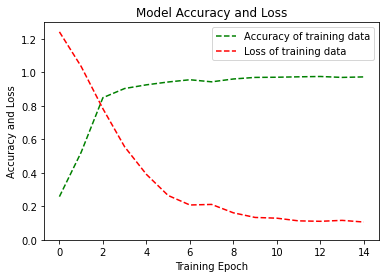

In [74]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [75]:
# Set input_shape / reshape for Keras
# Encode labels
Test_data['encoded_label'] = le.transform(Test_data['activity'].values.ravel())
print(list(le.classes_))

for i in range(0,6):
    print(data.columns[i])
    Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
    
x_test, y_test = create_segments(Test_data)
print("x shape: ",x_test.shape)
print("y shape: ",y_test.shape)

x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, len(LABELS))
y_test.shape

['Fall', 'Idle', 'Sitting action', 'Walking']
accel_x
mean:  0.05231241699867065
standard deviation:  0.40801866511330726
accel_y
mean:  -0.05762715803452509
standard deviation:  0.7795476927967934
accel_z
mean:  0.8252191235059748
standard deviation:  0.8118311559818603
gyro_x
mean:  0.05676859229747714
standard deviation:  86.05676081855844
gyro_y
mean:  0.7309349269588248
standard deviation:  58.4324993489224
gyro_z
mean:  -0.8028837981407743
standard deviation:  51.83655372696042
x shape:  (800, 60, 6)
y shape:  (800,)


(800, 4)

In [76]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

25/25 [==============================] - 0s 4ms/step - loss: 0.0638 - accuracy: 0.9862

Accuracy on test data: 0.99

Loss on test data: 0.06


In [77]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

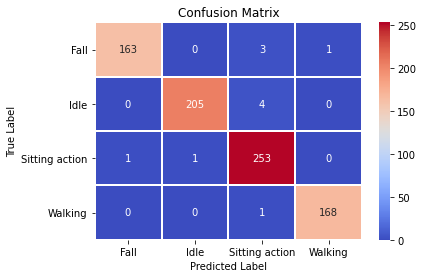


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       167
           1       1.00      0.98      0.99       209
           2       0.97      0.99      0.98       255
           3       0.99      0.99      0.99       169

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



In [78]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [79]:
model_m.save('best_model_cnn.h5')

In [80]:
print(mu)
print(sigma)

[0.05231241699867065, -0.05762715803452509, 0.8252191235059748, 0.05676859229747714, 0.7309349269588248, -0.8028837981407743]
[0.40801866511330726, 0.7795476927967934, 0.8118311559818603, 86.05676081855844, 58.4324993489224, 51.83655372696042]


### LSTM Model

In [22]:
model_lstm = Sequential()
model_lstm.add(LSTM(250, input_shape=(TIME_PERIODS,no_of_features)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(200, activation='relu'))
model_lstm.add(Dense(len(LABELS), activation='softmax'))
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               257000    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               50200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 308,004
Trainable params: 308,004
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(2004, 60, 6)

In [24]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

# opt = optimizers.RMSprop(learning_rate=0.001, momentum=0.9)

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lstm.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
11/11 [==============================] - 3s 51ms/step - loss: 1.3181 - accuracy: 0.4760
Epoch 2/50
11/11 [==============================] - 1s 49ms/step - loss: 1.0010 - accuracy: 0.5180
Epoch 3/50
11/11 [==============================] - 1s 48ms/step - loss: 0.9052 - accuracy: 0.5464
Epoch 4/50
11/11 [==============================] - 1s 48ms/step - loss: 0.8214 - accuracy: 0.5983
Epoch 5/50
11/11 [==============================] - 1s 49ms/step - loss: 0.7343 - accuracy: 0.6642
Epoch 6/50
11/11 [==============================] - 1s 48ms/step - loss: 0.6536 - accuracy: 0.7590
Epoch 7/50
11/11 [==============================] - 1s 50ms/step - loss: 0.7357 - accuracy: 0.6831
Epoch 8/50
11/11 [==============================] - 1s 48ms/step - loss: 0.6056 - accuracy: 0.7420
Epoch 9/50
11/11 [==============================] - 1s 49ms/step - loss: 0.5747 - accuracy: 0.7799
Epoch 10/50
11/11 [==============================] - 1s 50ms/step - loss: 0.4921 - accuracy: 0.8293
Epoch 11/

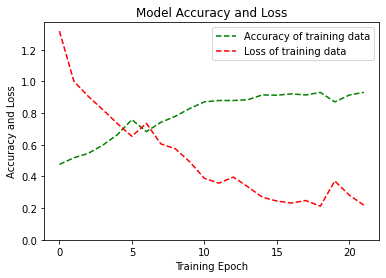

In [25]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [26]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(800, 60, 6)

In [27]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

25/25 [==============================] - 1s 12ms/step - loss: 0.2642 - accuracy: 0.9150

Accuracy on test data: 0.92

Loss on test data: 0.26


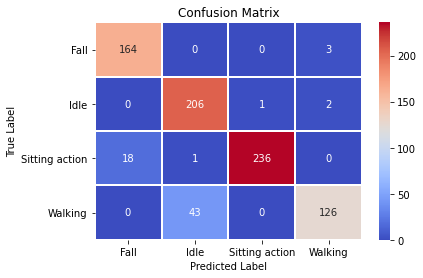


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       167
           1       0.82      0.99      0.90       209
           2       1.00      0.93      0.96       255
           3       0.96      0.75      0.84       169

    accuracy                           0.92       800
   macro avg       0.92      0.91      0.91       800
weighted avg       0.92      0.92      0.91       800



In [28]:
y_pred_test = model_lstm.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [29]:
model_lstm.save('best_model_lstm.h5')

### 1D CNN + LSTM Model

In [30]:
model_lsnet = Sequential()
model_lsnet.add(Conv1D(100, 3, activation='relu', input_shape=(TIME_PERIODS,no_of_features)))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(LSTM(250, return_sequences=True))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(Conv1D(80, 3, activation='relu'))
model_lsnet.add(GlobalAveragePooling1D())
model_lsnet.add(Dropout(0.4))
model_lsnet.add(Dense(100, activation='relu'))
model_lsnet.add(Dense(len(LABELS), activation='softmax'))
print(model_lsnet.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 58, 100)           1900      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19, 100)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 19, 250)           351000    
                                                                 
 conv1d_4 (Conv1D)           (None, 17, 100)           75100     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 100)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 80)            

In [31]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(2004, 60, 6)

In [32]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.RMSprop(learning_rate=0.001, momentum=0.9)

model_lsnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 100

history = model_lsnet.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/100
11/11 [==============================] - 4s 47ms/step - loss: 1.1406 - accuracy: 0.5269
Epoch 2/100
11/11 [==============================] - 0s 34ms/step - loss: 1.2146 - accuracy: 0.6891
Epoch 3/100
11/11 [==============================] - 0s 34ms/step - loss: 0.4760 - accuracy: 0.8633
Epoch 4/100
11/11 [==============================] - 0s 33ms/step - loss: 0.2395 - accuracy: 0.9381
Epoch 5/100
11/11 [==============================] - 0s 34ms/step - loss: 0.1403 - accuracy: 0.9631
Epoch 6/100
11/11 [==============================] - 0s 35ms/step - loss: 0.1308 - accuracy: 0.9661
Epoch 7/100
11/11 [==============================] - 0s 34ms/step - loss: 0.0944 - accuracy: 0.9736
Epoch 8/100
11/11 [==============================] - 0s 34ms/step - loss: 0.0944 - accuracy: 0.9731
Epoch 9/100
11/11 [==============================] - 0s 34ms/step - loss: 0.0906 - accuracy: 0.9780
Epoch 10/100
11/11 [==============================] - 0s 34ms/step - loss: 0.0976 - accuracy: 0.9716

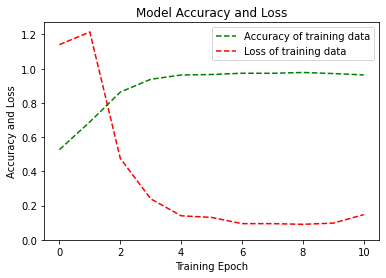

In [33]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [34]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(800, 60, 6)

In [35]:
score = model_lsnet.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

25/25 [==============================] - 1s 7ms/step - loss: 0.1734 - accuracy: 0.9600

Accuracy on test data: 0.96

Loss on test data: 0.17


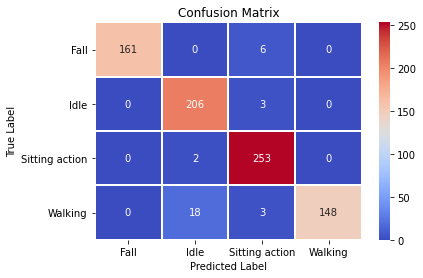


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       167
           1       0.91      0.99      0.95       209
           2       0.95      0.99      0.97       255
           3       1.00      0.88      0.93       169

    accuracy                           0.96       800
   macro avg       0.97      0.95      0.96       800
weighted avg       0.96      0.96      0.96       800



In [36]:
y_pred_test = model_lsnet.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [37]:
model_lsnet.save('best_model_lsnet.h5')

### Transfer Learning with CNN model trained from Sisfall data

In [38]:
from tensorflow.keras import Model 
model_pretrained = keras.models.load_model('best_model_cnn_online_data.h5')
model_pretrained.layers

for layer in model_pretrained.layers[:-2]:
    print(layer)
    layer.trainable = False

In [39]:
x = model_pretrained.layers[6].output
# x = GlobalAveragePooling1D()(x)
# x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(len(LABELS), activation='softmax')(x)
model_tr = Model(model_pretrained.input, output)

model_tr.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, 360)]             0         
                                                                 
 reshape (Reshape)           (None, 60, 6)             0         
                                                                 
 conv1d (Conv1D)             (None, 58, 100)           1900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 100)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 120)           36120     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 120)           0         
 1D)                                                         

In [40]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS * no_of_features)
x_train.shape

(2004, 360)

In [41]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

opt = optimizers.SGD(learning_rate=0.01, momentum = 0.9)

model_tr.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 100

history = model_tr.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 14ms/step - loss: 0.9657 - accuracy: 0.6687
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4471 - accuracy: 0.9067
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2908 - accuracy: 0.9276
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2251 - accuracy: 0.9336
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1766 - accuracy: 0.9536
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1779 - accuracy: 0.9486
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1558 - accuracy: 0.9531
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1395 - accuracy: 0.9601
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1442 - accuracy: 0.9556
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1365 - accuracy: 0.9601
Epo

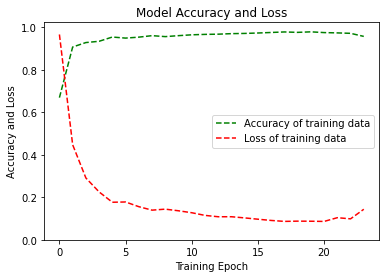

In [42]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [43]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS * no_of_features)
x_test.shape

(800, 360)

In [44]:
score = model_tr.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

25/25 [==============================] - 1s 4ms/step - loss: 0.0630 - accuracy: 0.9812

Accuracy on test data: 0.98

Loss on test data: 0.06


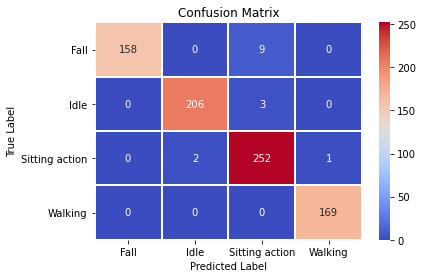


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       167
           1       0.99      0.99      0.99       209
           2       0.95      0.99      0.97       255
           3       0.99      1.00      1.00       169

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [45]:
y_pred_test = model_tr.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [46]:
model_tr.save('best_model_tr.h5')

### RNN Model

In [47]:
model_rnn = keras.Sequential()
model_rnn.add(Embedding(input_dim=TIME_PERIODS*no_of_features, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model_rnn.add(GRU(128, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.4))
model_rnn.add(Dense(len(LABELS), activation='softmax'))

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          23040     
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 110,148
Trainable params: 110,148
Non-trainable params: 0
_________________________________________________________________


In [48]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(2004, 360)

In [49]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

# opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_rnn.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
11/11 [==============================] - 10s 630ms/step - loss: 1.3743 - accuracy: 0.2829
Epoch 2/50
11/11 [==============================] - 8s 756ms/step - loss: 1.3441 - accuracy: 0.3378
Epoch 3/50
11/11 [==============================] - 10s 893ms/step - loss: 1.3642 - accuracy: 0.3353


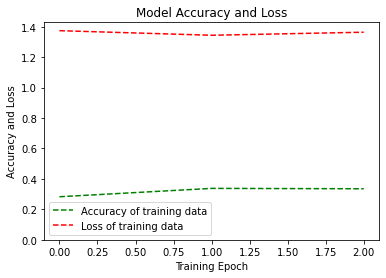

In [50]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [51]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)
x_test.shape

(800, 360)

In [52]:
score = model_rnn.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

25/25 [==============================] - 2s 69ms/step - loss: 1.3728 - accuracy: 0.3250

Accuracy on test data: 0.32

Loss on test data: 1.37


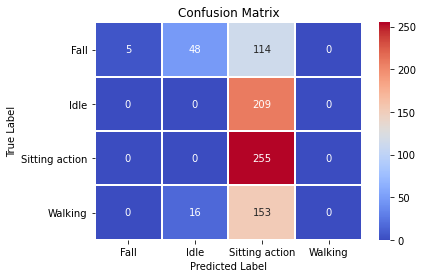


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       167
           1       0.00      0.00      0.00       209
           2       0.35      1.00      0.52       255
           3       0.00      0.00      0.00       169

    accuracy                           0.33       800
   macro avg       0.34      0.26      0.14       800
weighted avg       0.32      0.33      0.18       800



In [53]:
y_pred_test = model_rnn.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

# Making Predictions

In [83]:
data = pd.read_csv("new data/combined_data_new.csv")
data = data[data['activity']!="Jogging"]

Test_data = data[data["user"].isin(['Zeon'])]

activity = {'Fall': 0, 'Idle': 1, 'Sitting action': 2, 'Walking': 3}
Test_data['encoded_label'] = le.transform(Test_data['activity'].values.ravel())
print(le.classes_)

mu = [0.05231241699867065, -0.05762715803452509, 0.8252191235059748, 0.05676859229747714, 0.7309349269588248, -0.8028837981407743]
sigma = [0.40801866511330726, 0.7795476927967934, 0.8118311559818603, 86.05676081855844, 58.4324993489224, 51.83655372696042]


def normalize_features(data, mu_data, sigma_data):
    return (data - mu_data)/sigma_data

for i in range(0,6):
        Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
        
# Test_data = Test_data[100000:105000]
print(Test_data)

x_test_data, y_test_labels = create_segments(Test_data)
x_test_data = x_test_data.reshape(x_test_data.shape[0], TIME_PERIODS*no_of_features)
print("test data shape: ", x_test_data.shape)

model = keras.models.load_model('best_model_cnn.h5')

x_test_data = x_test_data.astype("float32")

pred = model.predict(x_test_data)
prediction = np.argmax(pred, axis=1)
print("Predictions:", prediction)
print("Actual:", y_test_labels)

['Fall' 'Idle' 'Sitting action' 'Walking']
       accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  user activity  \
30120   -0.373    0.087    0.117   0.012  -0.067   0.007  Zeon     Fall   
30121   -0.373    0.087    0.117   0.041  -0.109   0.051  Zeon     Fall   
30122   -0.349    0.087    0.129   0.040  -0.137   0.054  Zeon     Fall   
30123   -0.349    0.087    0.129   0.045  -0.141   0.050  Zeon     Fall   
30124   -0.324    0.087    0.129   0.042  -0.103   0.059  Zeon     Fall   
...        ...      ...      ...     ...     ...     ...   ...      ...   
42175   -0.275    0.035    0.067   0.036  -0.049   0.013  Zeon  Walking   
42176   -0.104    0.164    0.191  -0.081  -0.091   0.161  Zeon  Walking   
42177   -0.079    0.215    0.166  -0.174  -0.191   0.115  Zeon  Walking   
42178   -0.202    0.330   -0.117   0.393  -0.192  -0.204  Zeon  Walking   
42179   -0.373    0.369   -0.179   0.685  -0.403  -0.074  Zeon  Walking   

       encoded_label  
30120              0  
30121     